        E:\Data\FinalResults\Dsp\0857 - Initialization Unique Place Fields is already existed!


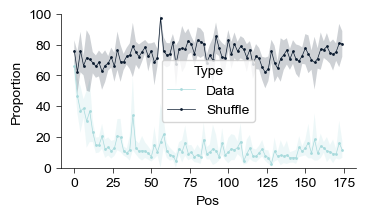

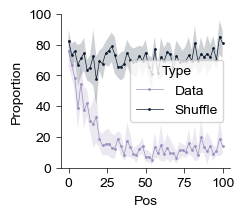

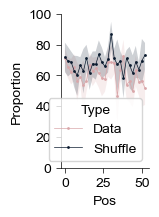

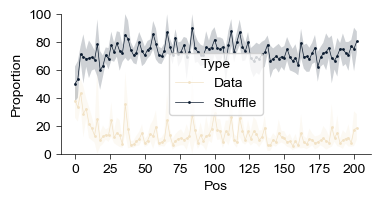

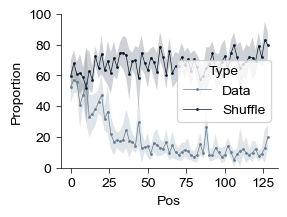

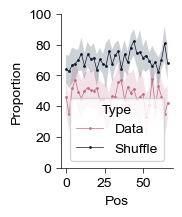

In [8]:
from mylib.statistic_test import *

code_id = '0857 - Initialization Unique Place Fields'
loc = os.path.join(figpath, 'Dsp', code_id)
mkdir(loc)

from mylib.dsp.tfar import field_register_dsp_old
def UniquePlaceFieldDuringInitialiation_DSP_Interface(trace, variable_names = None):
    VariablesInputErrorCheck(variable_names, ["Pos", "Proportion", "Route", "Type"])
    
    pos, propo, route = [], [], []
    types = []

    
    for is_shuffle in [False, True]:
        if is_shuffle == False:
            field_reg = np.where(trace['field_reg'] == 0, 0, 1)
            field_pos = trace['field_info'][:, :, 2]      
        else:
            field_reg, field_info = field_register_dsp_old(trace, overlap_thre=0.6, is_shuffle=True)
            field_reg = np.where(field_reg == 0, 0, 1)
            field_pos = field_info[:, :, 2]      
        
        for r in range(1, 7):
            if r in [1, 2, 3]:
                rt = r
                comple_routes = np.array([0, 4])
                initpos = 0
            else:
                rt = r+2
                comple_routes = np.array([5, 9])
                initpos = [2, 3, 4][r-4]
            
            n_active = np.sum(field_reg[comple_routes, :], axis=0)
            field_idx = np.where(n_active == comple_routes.shape[0])[0]  # Allocentric Field
            field_centers = S2F[field_pos[comple_routes[0], field_idx].astype(np.int64) - 1]
        
            idx_with_pos = np.isin(field_centers, np.intersect1d(CP_DSP[0], CP_DSP[r]))
            field_idx_with_pos = field_idx[idx_with_pos]
            field_centers = field_centers[idx_with_pos]
        
            occu = np.histogram(
                field_centers,
                range=(0.5, 144.5),
                bins=144
            )[0]
            occu[occu == 0] = 1e-8

            count = np.histogram(
                field_centers[field_reg[rt, field_idx_with_pos] == 1],
                range=(0.5, 144.5),
                bins=144
            )[0]
        
            frac = (count/occu)[CP_DSP[r][initpos:]-1]
            propo.append(frac)
            pos.append(np.arange(frac.shape[0]))
            route.append(np.repeat(r, frac.shape[0]))
            
            if is_shuffle:
                types.append(np.repeat("Shuffle", frac.shape[0]))
            else:
                types.append(np.repeat("Data", frac.shape[0]))
        
    return np.concatenate(pos), np.concatenate(propo), np.concatenate(route), np.concatenate(types)

if os.path.exists(os.path.join(figdata, f"{code_id}.pkl")):
    with open(os.path.join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = DataFrameEstablish(
        variable_names=["Pos", "Proportion", "Route", "Type"], f=f2,
        file_idx=np.where(f2['MiceID'] != 10209)[0],
        behavior_paradigm='DSPMaze',
        file_name=code_id,
        function=UniquePlaceFieldDuringInitialiation_DSP_Interface
    )

Data['Proportion'] = 1-Data['Proportion']

for r in range(1, 7):                 
    SubData = SubDict(Data, Data.keys(), np.where(Data['Route'] == r)[0])
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData['Proportion'] *= 100
    SubData['Pos'] *= 2
    sns.lineplot(
        x='Pos',
        y='Proportion',
        data=SubData,
        hue='Type',
        palette=[DSPPalette[r], '#0a1a2e'],
        linewidth=0.5,
        err_kws={'edgecolor':None},
        ax = ax,
        marker='o',
        markersize=2,
        markeredgewidth = 0
    )
    ax.set_ylim(0, 100)
    xlim = ax.get_xlim()
    ax.set_aspect("equal")
    ax.set_xticks(np.linspace(0, 225, 10))
    ax.set_xlim(xlim)
    plt.savefig(os.path.join(loc, f"Route {r}.svg"), dpi=600)
    plt.savefig(os.path.join(loc, f"Route {r}.png"), dpi=600)
    plt.show()
    